# CPI Predictors
Which forward looking CPI estimates best predict actual CPI and Core CPI based on historical data since 1982? In this notebook I put the following ones to the test:
* `STICKCPIM158SFRBATL` &mdash; Sticky Price Consumer Price Index (aka Sticky CPI). The Federal Reserve Bank of Atlanta calculates it from a subset of goods and services included in the CPI that change price relatively infrequently. Because these goods and services change price relatively infrequently, they are thought to incorporate expectations about future inflation to a greater degree than prices that change on a more frequent basis.
* `EXPINF1YR` &mdash; An estimate of CPI over the next 12 months from the Federal Reserve bank of Cleveland. Its inflation expectation model uses the following inputs:
  - Blue Chip forecast of CPI
  - Inflation swap data
  - CPI numbers for the current month
  - CPI data from vintage FRED
  - 1-month to 6-month treasury bill yield at constant maturity
  - 1-year to 15-year US treasury yield: continuously compounded zero-coupon
  - Survey of Professional Forecasters median year-over-year CPI inflation rate for the next 10 years
* `MICH` &mdash; A survey-based estimate of CPI over the next 12 months from University of Michigan.

I shift the respective Sticky CPI, Fed Reserve Bank of Cleveland 1-Year Expectated Inflation, and University of Michigan inflation expectation publications by 1 to 12 months forward and take [the root mean square error (RMSE)](https://en.wikipedia.org/wiki/Root-mean-square_deviation) between them and the actual CPI and core CPI in that month.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import pandas_datareader.data as web
from datetime import date
from pandas.tseries.offsets import MonthBegin, DateOffset

In [2]:
report_start = date.fromisoformat('1959-01-01')
report_end = date.today()

In [3]:
cpis = web.get_data_fred(['CPIAUCSL', 'CPILFESL', 'STICKCPIM158SFRBATL', 'EXPINF1YR', 'MICH'], start=report_start, end=report_end)
cpis.iloc[:,2:] /= 100.

# Expected inflation from Reserve Bank of Cleveland needs to be shifted backward by a month given the way
# the FRED publishes the data
cpis.update(cpis.EXPINF1YR.shift(-1))

cpis.update(cpis.iloc[:,:2].pct_change(12, fill_method=None))
cpis.dropna(inplace=True)

In [4]:
cpis.rename(
    columns={'STICKCPIM158SFRBATL': 'Sticky CPI (Reserve Bank of Atlanta)',
             'EXPINF1YR': '1-Year Expected Inflation (Reserve Bank of Cleveland)',
             'MICH': '1-Year Expected Inflation (University of Michigan)'},
    inplace=True)

In [5]:
cpis

,CPIAUCSL,CPILFESL,Sticky CPI (Reserve Bank of Atlanta),1-Year Expected Inflation (Reserve Bank of Cleveland),1-Year Expected Inflation (University of Michigan)
DATE,,,,,
1981-12-01,0.089120,0.095406,0.047058,0.063945,0.053
1982-01-01,0.082569,0.092506,0.045707,0.064321,0.051
1982-02-01,0.076136,0.091967,0.051338,0.063877,0.052
1982-03-01,0.068849,0.086806,0.002319,0.061406,0.042
1982-04-01,0.066218,0.088506,0.106899,0.054882,0.047
...,...,...,...,...,...
2024-09-01,0.024325,0.032899,0.037440,0.022561,0.027
2024-10-01,0.025714,0.032928,0.036522,0.024317,0.027
2024-11-01,0.027142,0.032801,0.026594,0.026504,0.026


In [6]:
def rmse(series_diff):
    return np.sqrt((series_diff**2).mean())

In [7]:
def construct_rmse_dataframe(date_from=None):
    """
    :param date_from: a datetime.date or pandas.Timestamp object indicating if
                      the calculation of RMSE should be limited to the range of months starting from the given date
    """
    rmse_cpi = []
    rmse_core_cpi = []
    rmse_cpi_exp = []
    rmse_core_cpi_exp = []
    rmse_cpi_mich = []
    rmse_core_cpi_mich = []

    _cpis = cpis if date_from is None else cpis.loc[date_from:]
                   
    idx = pd.Index(range(1, 13), name='Sticky CPI/Expected Inflation forward shift in months')
    for i in idx:
        cpis_shifted = pd.concat([_cpis.iloc[:,:2], _cpis.iloc[:,2:].shift(i)], axis=1)
        rmse_cpi.append(rmse(cpis_shifted.iloc[:,0]-cpis_shifted.iloc[:,2]))
        rmse_core_cpi.append(rmse(cpis_shifted.iloc[:,1]-cpis_shifted.iloc[:,2]))
        rmse_cpi_exp.append(rmse(cpis_shifted.iloc[:,0]-cpis_shifted.iloc[:,3]))
        rmse_core_cpi_exp.append(rmse(cpis_shifted.iloc[:,1]-cpis_shifted.iloc[:,3]))
        rmse_cpi_mich.append(rmse(cpis_shifted.iloc[:,0]-cpis_shifted.iloc[:,4]))
        rmse_core_cpi_mich.append(rmse(cpis_shifted.iloc[:,1]-cpis_shifted.iloc[:,4]))
    
    return pd.DataFrame(np.array([rmse_cpi, rmse_core_cpi, rmse_cpi_exp, rmse_core_cpi_exp, rmse_cpi_mich, rmse_core_cpi_mich]).T,
                index=idx, columns=['RMSE: CPI and Sticky CPI', 'RMSE: Core CPI and Sticky CPI',
                                    'RMSE: CPI and 1y Expected Infl', 'RMSE: Core CPI and 1y Expected Infl',
                                    'RMSE: CPI and Mich Infl Exp', 'RMSE: Core CPI and Mich Infl Exp'])

In [8]:
df_cpi_predictors = construct_rmse_dataframe()
date_for_last_10y = report_end - DateOffset(years=+10) - MonthBegin()
date_for_last_5y = report_end - DateOffset(years=+5) - MonthBegin()
df_cpi_predictors_last_10y = construct_rmse_dataframe(date_for_last_10y)
df_cpi_predictors_last_5y = construct_rmse_dataframe(date_for_last_5y)

In [9]:
df_cpi_predictors

,RMSE: CPI and Sticky CPI,RMSE: Core CPI and Sticky CPI,RMSE: CPI and 1y Expected Infl,RMSE: Core CPI and 1y Expected Infl,RMSE: CPI and Mich Infl Exp,RMSE: Core CPI and Mich Infl Exp
Sticky CPI/Expected Inflation forward shift in months,,,,,,
1,0.014982,0.012184,0.012936,0.009272,0.012261,0.011545
2,0.015338,0.012221,0.013020,0.009143,0.012332,0.011261
3,0.015842,0.012426,0.013191,0.009057,0.012451,0.011008
4,0.016508,0.012709,0.013430,0.009040,0.012663,0.010810
5,0.017046,0.012792,0.013696,0.009055,0.012957,0.010655
6,0.017384,0.012846,0.013987,0.009119,0.013249,0.010567
7,0.017782,0.013036,0.014254,0.009217,0.013590,0.010542
8,0.018099,0.013087,0.014525,0.009377,0.014021,0.010593
9,0.018461,0.013201,0.014957,0.009560,0.014463,0.010698


The purpose of the University of Michigan's inflation expectation indicator and the Federal Reserve Bank of Cleveland's 1-Year Expected Inflation measure is to predict the annual growth rate of the CPI in one year. In the graph below, they are intended to predict CPI inflation with a forward shift of 12 months. I have thickened the horizontal line to ensure it stands out in the graph.

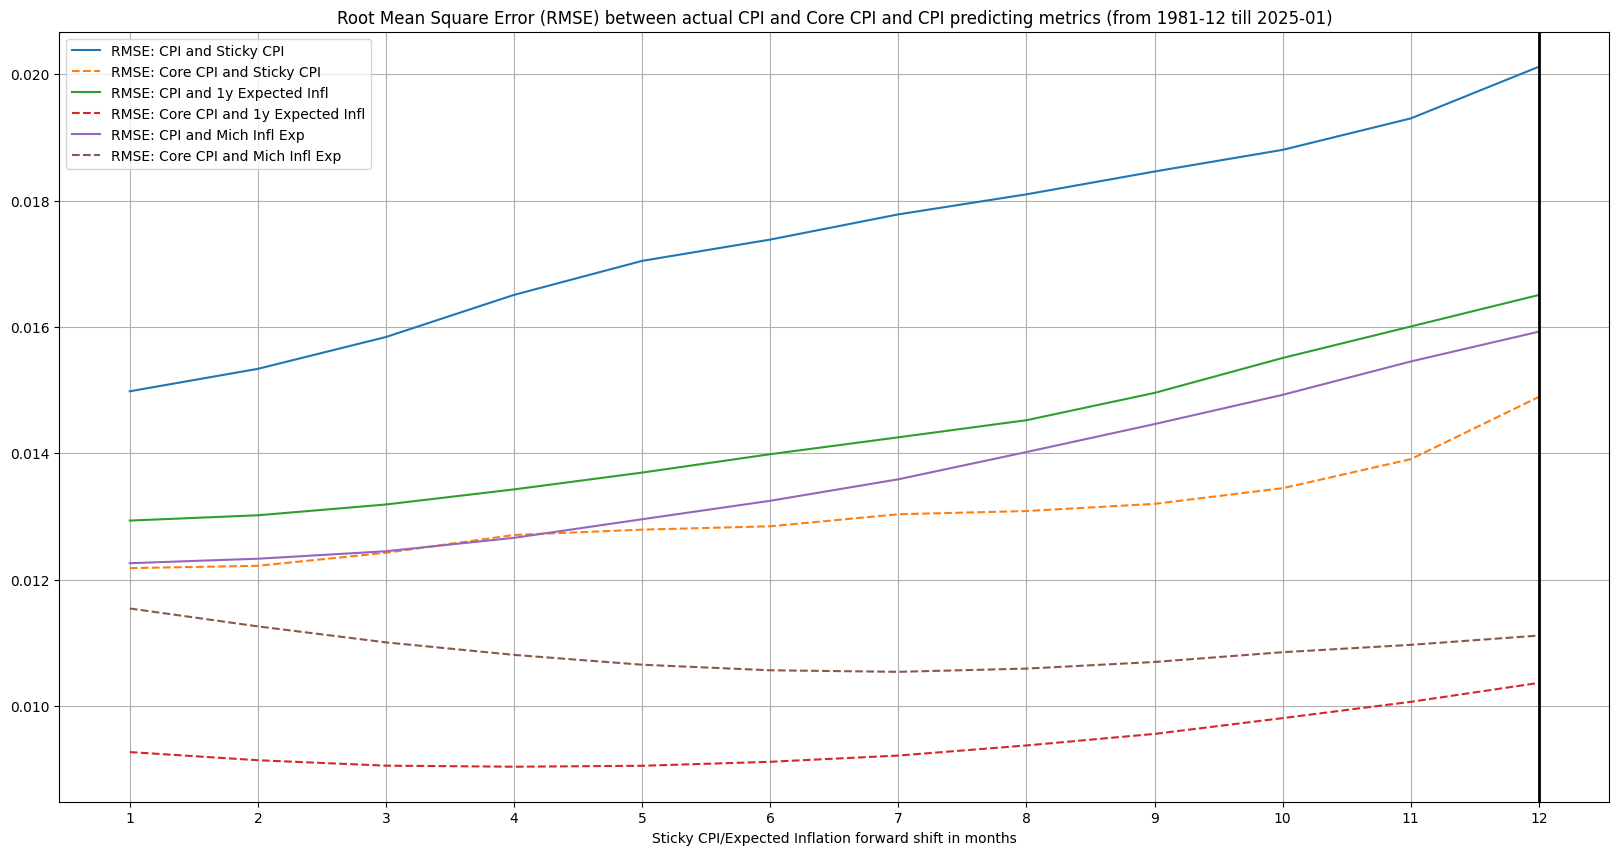

In [10]:
ax = df_cpi_predictors.plot(
        figsize=(20,10), grid=True,
        title='Root Mean Square Error (RMSE) between actual CPI and Core CPI and CPI predicting metrics (from {:%Y-%m} till {:%Y-%m})'
            .format(cpis.index[0].date(), cpis.index[-1].date()),
        xticks=df_cpi_predictors.index, style=['-', '--']*3)
_ = ax.axvline(df_cpi_predictors.index[-1], color='k', lw=2)

### Conclusion
1. The Federal Reserve Bank of Cleveland estimate of 1-Year Expected Inflation is head and shoulders the best predictor of actual Core CPI over the next 12 months. Despite its intent of predicting CPI over the next year, it is actually most effective at predicting Core CPI within 2 months.
2. The University of Michigan's Inflation Expectation for the next 12 months is the best predictor of overall CPI over the next year. Despite its aim to predict CPI over the next year, it is most accurate at forecasting CPI for the following three months.

## Limiting the analysis to the last 10 and 5 years
It's interesting to see if the conclusion would remain the same if we limit the calculation of RMSE to the last 10 and 5 years.

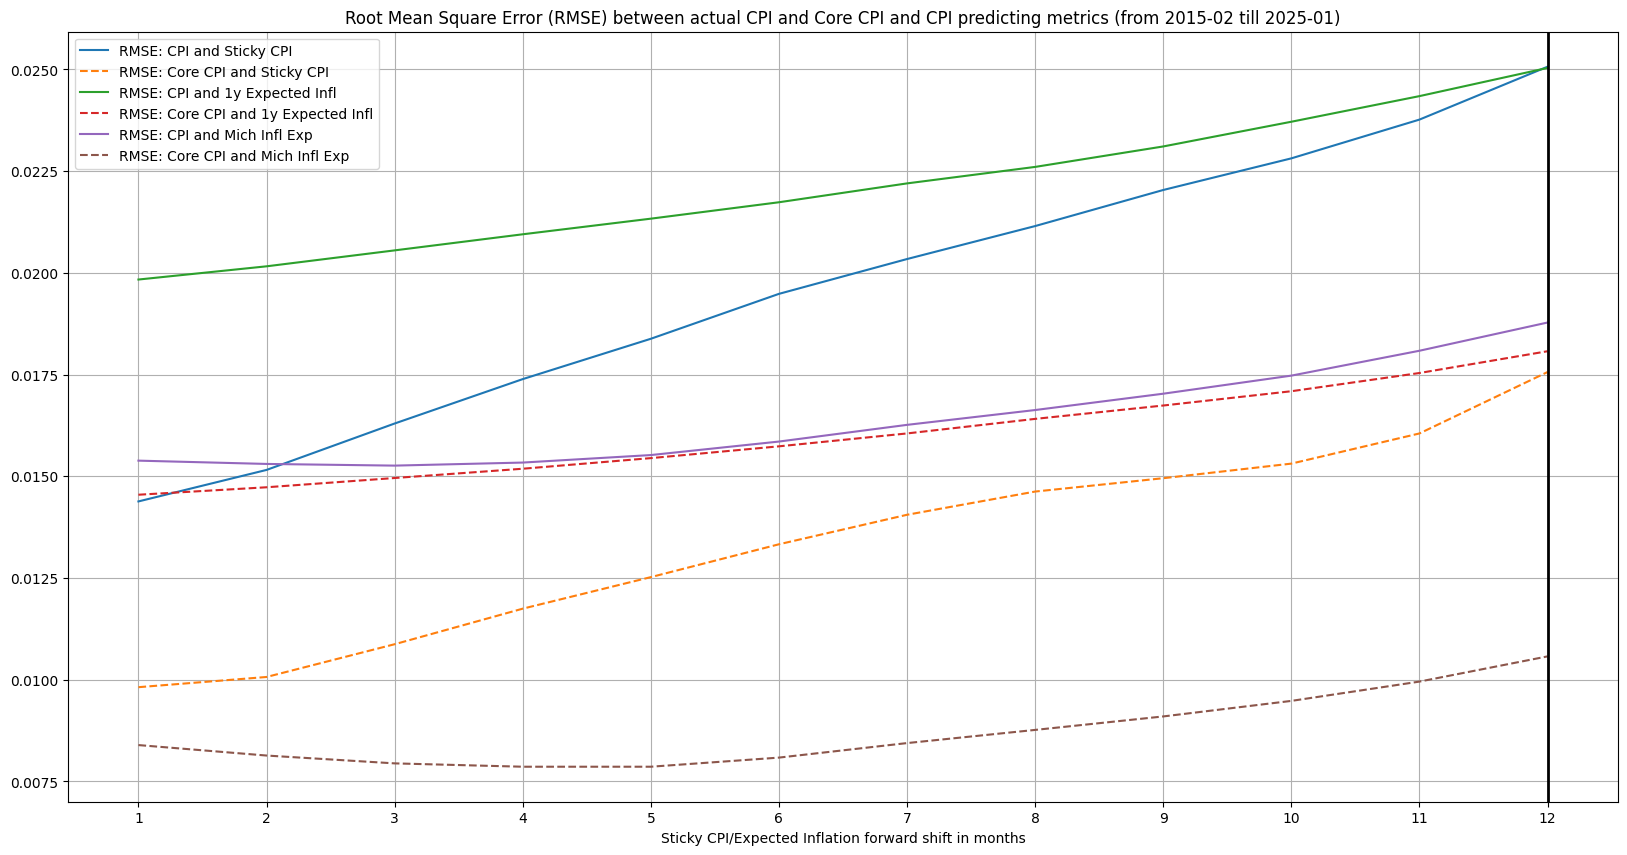

In [11]:
ax = df_cpi_predictors_last_10y.plot(
        figsize=(20,10), grid=True,
        title='Root Mean Square Error (RMSE) between actual CPI and Core CPI and CPI predicting metrics (from {:%Y-%m} till {:%Y-%m})'
            .format(date_for_last_10y, cpis.index[-1].date()),
        xticks=df_cpi_predictors_last_10y.index, style=['-', '--']*3)
_ = ax.axvline(df_cpi_predictors.index[-1], color='k', lw=2)

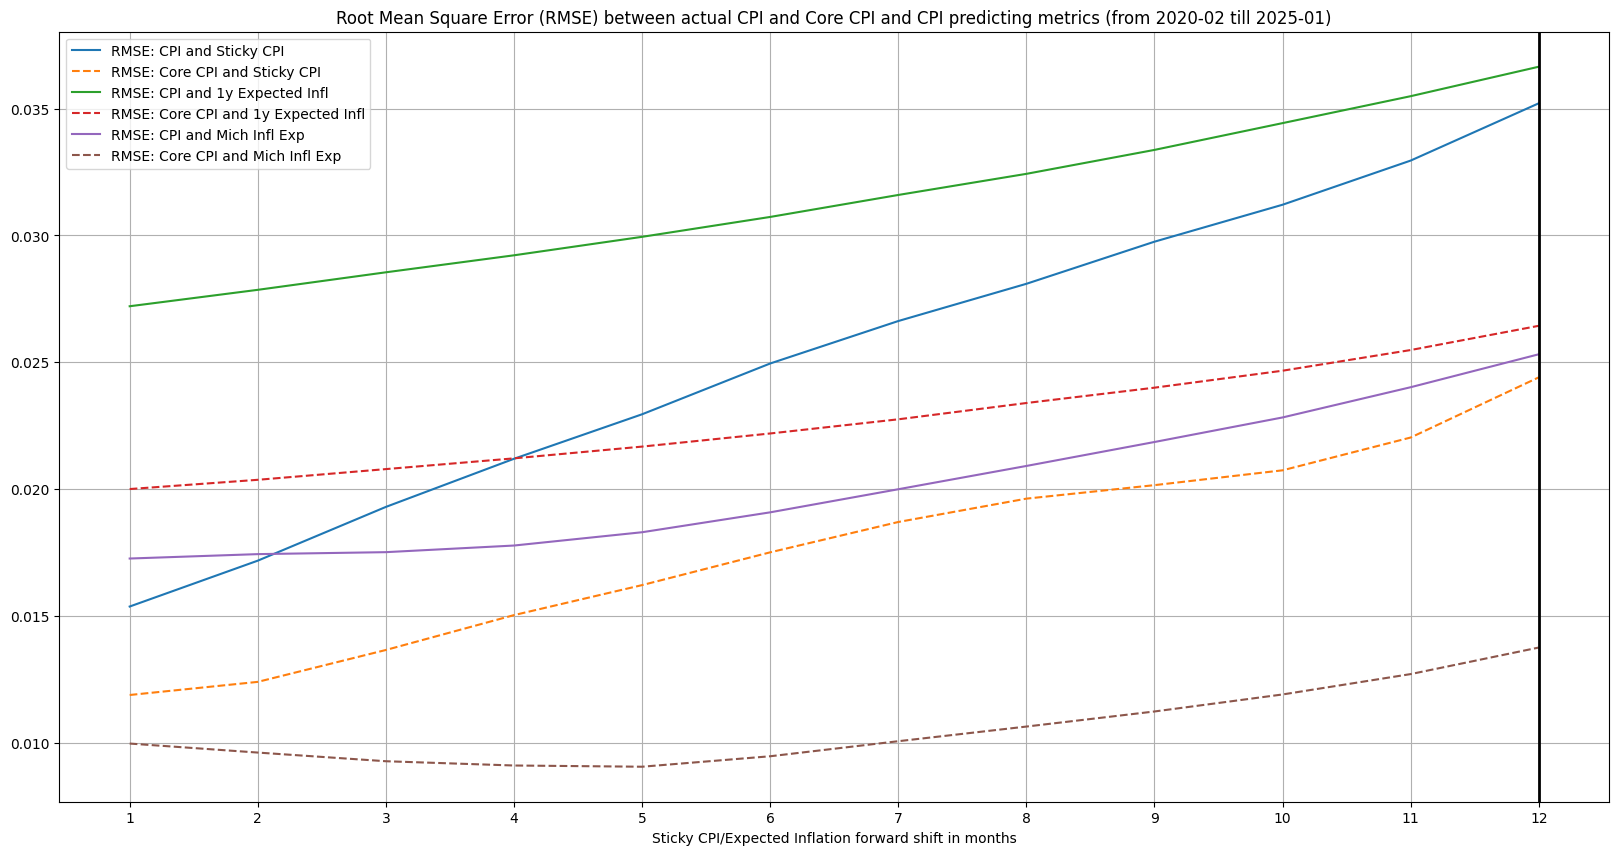

In [12]:
ax = df_cpi_predictors_last_5y.plot(
        figsize=(20,10), grid=True,
        title='Root Mean Square Error (RMSE) between actual CPI and Core CPI and CPI predicting metrics (from {:%Y-%m} till {:%Y-%m})'
            .format(date_for_last_5y, cpis.index[-1].date()),
        xticks=df_cpi_predictors_last_5y.index, style=['-', '--']*3)
_ = ax.axvline(df_cpi_predictors.index[-1], color='k', lw=2)

### Conclusion 2
When we limit the comparison to the past 10 and 5 years, the main differences are:
1. The University of Michigan's Inflation Expectation for the next 12 months is by far the best at predicting the Core CPI as well as overall CPI over the next 12 months (when we take the entire period from 1982, this indicator is the best only at predicting overall CPI inflation).
2. Sticky CPI does a better job at predicting both Core CPI and overall CPI over a 1-year time horizon than the Federal Reserve Bank of Cleveland's estimate of 1-Year Expected Inflation.

In [13]:
import seaborn as sns
cm = sns.color_palette('Blues', as_cmap=True)
IDX_FORMAT = '{:%Y-%m}'
pd.options.display.max_rows = 15

In [14]:
cpis.iloc[:,[3,4]].tail(18).style.format_index(IDX_FORMAT).format('{:.2%}')\
    .set_properties(subset=cpis.columns[[3,4]], **{'width': '200px'})\
    .set_table_styles([{'selector': 'th', 'props': 'text-align: right; width: 100px'}])\
    .background_gradient(cmap=cm)

,1-Year Expected Inflation (Reserve Bank of Cleveland),1-Year Expected Inflation (University of Michigan)
DATE,,
2023-08,2.81%,3.50%
2023-09,2.77%,3.20%
2023-10,2.79%,4.20%
2023-11,3.09%,4.50%
2023-12,2.42%,3.10%
2024-01,2.43%,2.90%
2024-02,2.08%,3.00%
2024-03,2.70%,2.90%
2024-04,2.94%,3.20%
